In [1]:
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
import scipy.spatial as scspatial
from desmin_reconstruction.plotting import line_and_bandplot
from desmin_reconstruction.plotting.renderings import render_pointcloud
from desmin_reconstruction.voronoi import random_uniform_like, VoronoiAnalysis
from tqdm import tqdm


plt.rc("font", size=12)
plt.rc("grid", linestyle="--", color="lightgray")
plt.rc("axes.spines", right=False, top=False)
pv.set_jupyter_backend("static")

## Import and visualize dSTORM raw data

In [2]:
df = pl.read_csv("../data/STORM/desmin_alphaactinin_600nm.csv")
df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])
out = df.partition_by("probe")

In [3]:
out[0]

shape: (77_586, 32)
┌──────────┬───────┬────────┬───────┬───┬───────┬────────┬────────┬────────┐
│ image-ID ┆ cycle ┆ z-step ┆ frame ┆ … ┆ valid ┆ driftx ┆ drifty ┆ driftz │
│ ---      ┆ ---   ┆ ---    ┆ ---   ┆   ┆ ---   ┆ ---    ┆ ---    ┆ ---    │
│ i64      ┆ i64   ┆ i64    ┆ i64   ┆   ┆ i64   ┆ i64    ┆ i64    ┆ i64    │
╞══════════╪═══════╪════════╪═══════╪═══╪═══════╪════════╪════════╪════════╡
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ …        ┆ …     ┆ …      ┆ …     ┆ … ┆ …     ┆ …      ┆ …      ┆ …      │
│ 7999     ┆ 3     ┆ 0      ┆ 1999  ┆ … ┆ 1     ┆ 22     ┆ 0      ┆ 0      │
│ 7999     ┆ 3     ┆ 0      ┆ 1999  ┆ … ┆ 1     ┆ 22     ┆ 0      ┆ 0      │
│ 7999     ┆ 3     ┆ 0      ┆ 1999  ┆ … ┆ 1     ┆ 22     ┆ 0      ┆ 0      │
│ 7999     ┆ 3     ┆ 0      ┆ 1999  ┆ … ┆ 1     ┆ 22     ┆ 0      ┆ 0      │
│ 7999     ┆ 3     ┆ 0      ┆ 1999  ┆ … ┆ 1     ┆ 22     ┆ 0      ┆ 0      │
└──────────┴───────┴────────┴───────┴───┴───────┴────────┴────────┴────────┘

Text(0.5, 0.01, 'x (μm)')

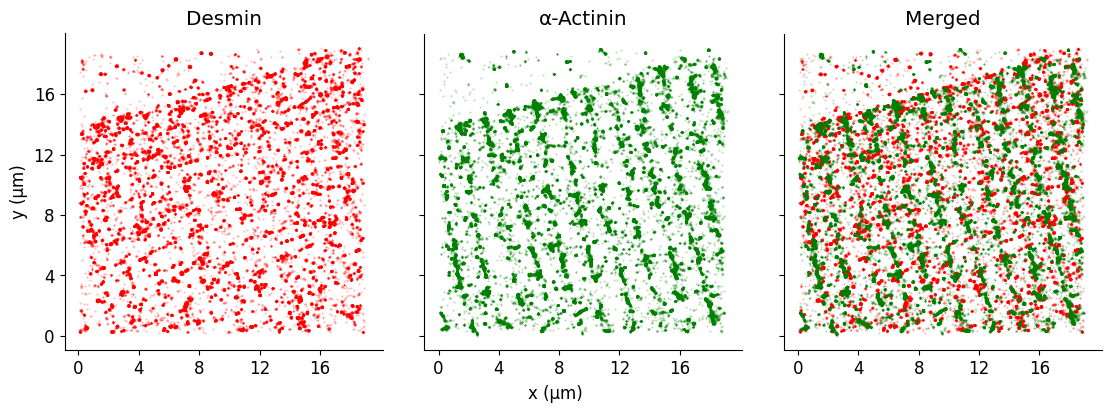

In [5]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        s=0.2,
        c="red",
        # c=np.log10(out[0]["amp"]),
        # cmap=cc.cm.kr_r,
        alpha=0.3,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        s=0.2,
        c="green",
        # c=np.log10(out[1]["amp"]),
        # cmap=cc.cm.kg_r,
        alpha=0.3,
    )

for ax, title in zip(axes, ("Desmin", "α-Actinin", "Merged")):
    ax.set_aspect("equal", "box")
    # ax.set_xlim((-0.2, 19.3))
    # ax.set_ylim((-0.2, 19.3))
    ax.set_xticks(np.arange(0, 20, 4))
    ax.set_yticks(np.arange(0, 20, 4))
    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

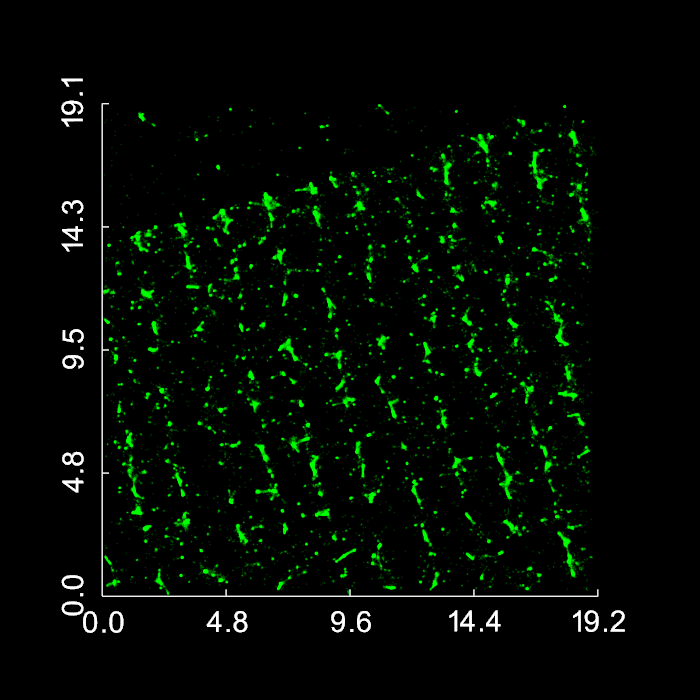

In [ ]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
p = render_pointcloud(
    p, out[0].select(["x", "y", "z"]).to_numpy(), color="#FF0000", opacity=0.0
)
p = render_pointcloud(
    p, out[1].select(["x", "y", "z"]).to_numpy(), color="#00FF00", opacity=0.2
)
p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
# p.save_graphic("../figures/supp_fig_1a/alpha-actinin.svg")

In [ ]:
voros = [VoronoiAnalysis(o.select(["x", "y", "z"]).to_numpy()) for o in out]
voro_vols = [v.region_volumes for v in voros]

100%|██████████| 154160/154160 [00:41<00:00, 3705.29it/s]


In [ ]:
def determine_threshold(localizations, n_trials: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    volumes = []
    for _ in tqdm(range(n_trials)):
        voro_rand = VoronoiAnalysis(random_uniform_like(localizations, rng))
        volumes.append(voro_rand.region_volumes)
    return volumes


voro_vol_rands = [determine_threshold(v.points) for v in voros]

100%|██████████| 10/10 [08:50<00:00, 53.05s/it]


In [12]:
voro_vol_rands_ = [np.stack(v, axis=0) for v in voro_vol_rands]
for v in voro_vol_rands_:
    print(v.shape)

(10, 77586)
(10, 154160)


In [13]:
savepath = "./data/results/desmin_alphaactinin_600nm_voronoi_volumes.npz"
np.savez(
    savepath,
    desmin=voro_vols[0],
    alpha_actinin=voro_vols[1],
    desmin_random=voro_vol_rands_[0],
    alpha_actinin_random=voro_vol_rands_[1],
)

In [16]:
voronoi_volumes = np.load(
    "../data/results/desmin_alphaactinin_600nm_voronoi_volumes.npz"
)

In [17]:
def histogram_fixed_binsize(values, bin_size, min_value=0.0, max_value=np.inf):
    values_valid = values[~np.isnan(values)]
    values_valid = np.clip(values_valid, min_value, max_value)
    bins = np.arange(min_value, max_value, bin_size)
    return np.histogram(values_valid, bins, density=True)


def internal_division_point(x1, x2, y1, y2):
    return (y1 * x2 + y2 * x1) / (y1 + y2)


def find_crossing_points(x, y1, y2):
    y_diff = y1 - y2
    x_exact_crossing = x[np.flatnonzero(y_diff == 0)]

    ind_sign_change = np.flatnonzero(y_diff[:-1] * y_diff[1:] <= 0)
    print(ind_sign_change)
    x_interped_crossing = internal_division_point(
        x[ind_sign_change],
        x[ind_sign_change + 1],
        y_diff[ind_sign_change],
        -y_diff[ind_sign_change + 1],
    )
    x_crossing = np.concatenate((x_exact_crossing, x_interped_crossing), axis=0)
    return np.sort(x_crossing)

[7.11864663e-03 4.69884335e-01 2.15364605e+00 ... 1.06808900e-02
 1.06784985e-02 2.51503514e-11]
[   5   73   74 ... 3997 3998 3999]
[0.00000000e+00 3.01480362e-02 2.78855333e-01 ... 2.26113208e-02
 2.26099500e-02 7.76524821e-13]
[  11  140  141 ... 3982 3986 3988]


/tmp/ipykernel_2629266/2330920824.py:9: RuntimeWarning: invalid value encountered in divide
  return (y1 * x2 + y2 * x1) / (y1 + y2)


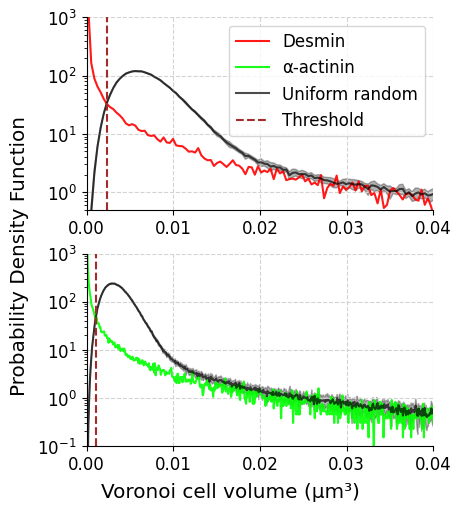

In [ ]:
vol_thresholds = []

fig, axes = plt.subplots(
    2,
    1,
    figsize=(4.5, 5),
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
names = ("desmin", "alpha_actinin")
color_dict = {"desmin": "#FF0000", "alpha_actinin": "#00FF00"}
title_dict = {"desmin": "Desmin", "alpha_actinin": "α-actinin"}
for ax, n in zip(axes, names):
    volumes_all = np.concatenate(
        [voronoi_volumes[k].flatten() for k in (n, f"{n}_random")], axis=0
    )
    volumes_all = volumes_all[np.isfinite(volumes_all)]
    bin_edges = np.histogram_bin_edges(
        volumes_all[volumes_all <= np.percentile(volumes_all, 97.5)], bins=4000
    )
    bin_edges = np.concatenate((bin_edges, np.max(volumes_all, keepdims=True)), axis=0)
    counts = np.histogram(voronoi_volumes[n], bin_edges, density=True)[0]
    counts_rand = np.stack(
        [
            np.histogram(vol, bin_edges, density=True)[0]
            for vol in voronoi_volumes[f"{n}_random"]
        ],
        axis=0,
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, counts, alpha=0.9, color=color_dict[n], label=title_dict[n])
    counts_rand_mean = np.mean(counts_rand, axis=0)
    ax = line_and_bandplot(
        ax,
        bin_centers,
        counts_rand_mean,
        np.std(counts_rand, axis=0),
        color="black",
        alpha=0.7,
        label="Uniform random",
    )
    ax.set_yscale("log")

    print(counts_rand_mean)
    vol_thres = find_crossing_points(bin_centers, counts, counts_rand_mean)[0]
    vol_thresholds.append(vol_thres)
    ax.axvline(x=vol_thres, linestyle="--", color="brown", label="Threshold")
    ax.grid(ls="--", color="lightgray")

l0, h0 = axes[0].get_legend_handles_labels()
l1, h1 = axes[1].get_legend_handles_labels()
# fig.legend([l0[0], *l1], [h0[0], *h1], loc="outside center right")
axes[0].legend([l0[0], *l1], [h0[0], *h1], loc="upper right")

axes[0].set_xlim((0, 0.04))
axes[-1].set_xlim((0, 0.04))
axes[0].set_ylim((5e-1, 1e3))
axes[1].set_ylim((1e-1, 1e3))
fig.supxlabel("Voronoi cell volume (μm³)", fontsize="large")
fig.supylabel("Probability Density Function", fontsize="large")
fig.savefig("../figures/supp_fig_1c.svg", dpi=500)

In [43]:
vol_thresholds

[np.float64(0.0023195670927630067), np.float64(0.0010387951338479459)]

In [19]:
df_filtered = [
    pl.concat(
        (
            out[i],
            pl.DataFrame({"voronoi_volume": voronoi_volumes[n]}),
        ),
        how="horizontal",
    ).filter(pl.col("voronoi_volume") <= vol_thresholds[i])
    for i, n in enumerate(("desmin", "alpha_actinin"))
]
df_filtered_total = pl.concat(df_filtered)

In [ ]:
# df_filtered_total.write_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")

In [13]:
df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")
out = df.partition_by("probe")

Text(0.5, 0.01, 'x (μm)')

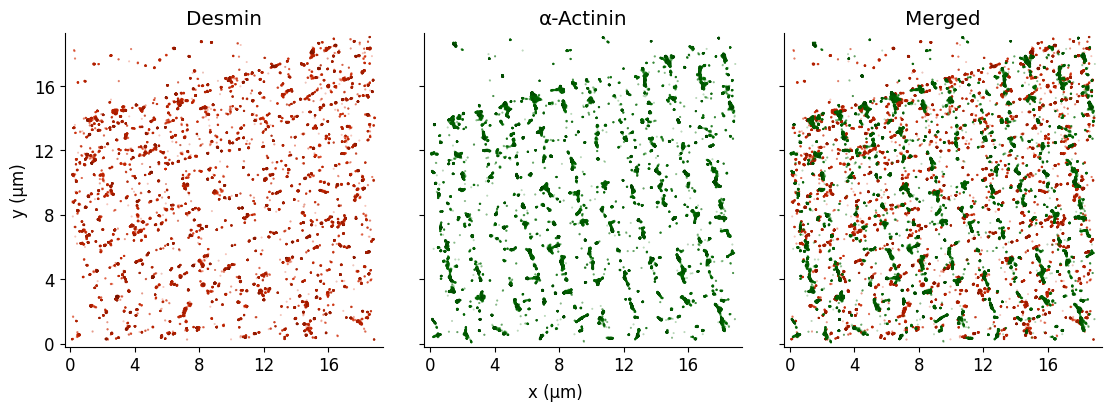

In [14]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2, "edgecolor": None, "vmax": 9, "vmin": 2.5}

fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        c=np.log10(1 / out[0]["voronoi_volume"]),
        cmap=cc.cm.kr_r,
        **scatter_kwargs,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        c=np.log10(1 / out[1]["voronoi_volume"]),
        cmap=cc.cm.kg_r,
        **scatter_kwargs,
    )

for ax, title in zip(axes, ("Desmin", "α-Actinin", "Merged")):
    ax.axis("equal")
    # ax.set_xlim((-0.2, 19.3))
    ax.set_ylim((-0.2, 19.3))
    ax.set_xticks(np.arange(0, 20, 4))
    ax.set_yticks(np.arange(0, 20, 4))
    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

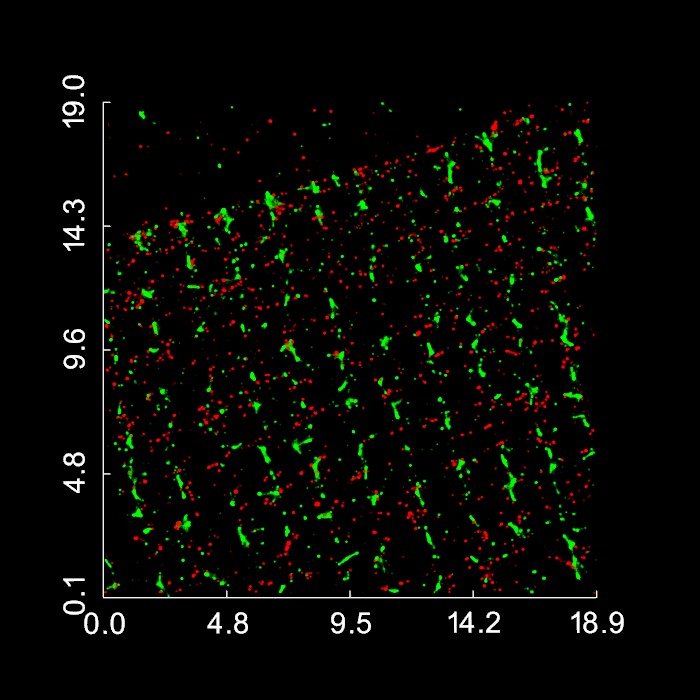

In [16]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
p = render_pointcloud(
    p, out[0].select(["x", "y", "z"]).to_numpy(), color="#FF0000", opacity=0.2
)
p = render_pointcloud(
    p, out[1].select(["x", "y", "z"]).to_numpy(), color="#00FF00", opacity=0.2
)
p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
# p.save_graphic("../figures/supp_fig_1b/desmin.svg")

(array([6510., 6995., 7980., 9070., 9511., 7594., 4919., 2099.,  523.,
          46.]),
 array([-6.04133578, -5.6056092 , -5.16988262, -4.73415603, -4.29842945,
        -3.86270287, -3.42697629, -2.9912497 , -2.55552312, -2.11979654,
        -1.68406996]),
 <BarContainer object of 10 artists>)

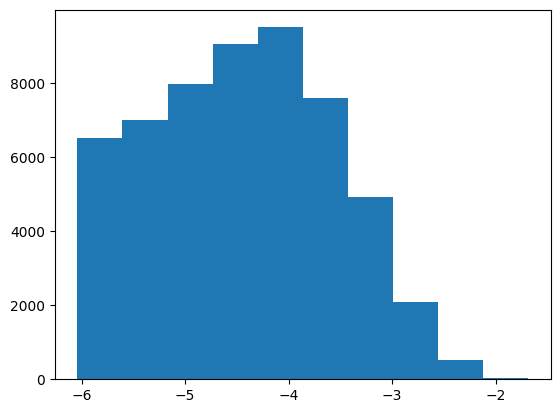

In [17]:
plt.hist(np.log10(1 / vols_desmin))

In [21]:
from hdbscan import HDBSCAN


clusterer = HDBSCAN(min_cluster_size=500, min_samples=25, cluster_selection_epsilon=30)
clusterer.fit(points_actinin_filtered[:, np.array([0, 2])])


HDBSCAN(cluster_selection_epsilon=30, min_cluster_size=500, min_samples=25)

In [22]:
set(clusterer.labels_)

{np.int64(-1),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44)}

In [26]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    cmap = plt.get_cmap("cet_glasbey_light")
    colors = [cmap(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        ax.scatter(
            *X[labels == k].T,
            s=1 if k == -1 else 2,
            marker=".",
            facecolor=tuple(col),
            edgecolor=None,
            alpha=0.7,
        )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    title = f"Estimated number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

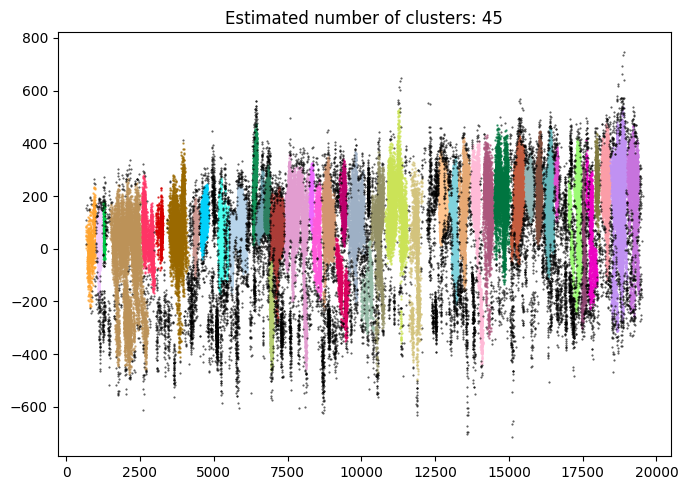

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_actinin_filtered[:, np.array([0, 2])], clusterer.labels_, ax=ax)

In [ ]:
import sklearn


sklearn.metrics.calinski_harabasz_score(
    points_actinin_filtered[:, np.array([0, 2])], clusterer.labels_
)

26144.67735405349

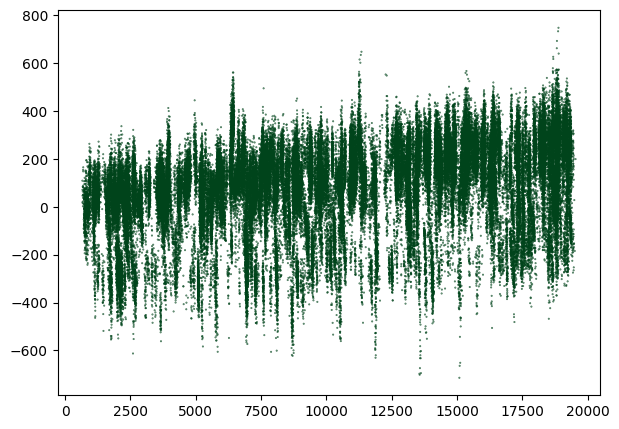

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(
    *(points_actinin_filtered.T[np.array([0, 2])]),
    c=np.log10(vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)

In [30]:
clusterer = HDBSCAN(min_cluster_size=1000, min_samples=20, cluster_selection_epsilon=50)
metrics = []

angles = np.linspace(0, 15, 50)
for theta in tqdm(angles):
    r = scspatial.transform.Rotation.from_rotvec(
        theta * np.array([0, 0, -1]), degrees=True
    )
    points_rotated = r.apply(points_actinin_filtered)
    clusterer.fit(points_rotated[:, np.array([0, 2])])

    metrics.append(
        sklearn.metrics.calinski_harabasz_score(
            points_rotated[:, np.array([0, 2])], clusterer.labels_
        )
    )

100%|██████████| 50/50 [02:04<00:00,  2.48s/it]


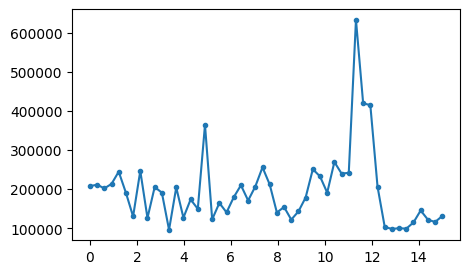

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(angles, np.array(metrics), ".-")

In [32]:
r = scspatial.transform.Rotation.from_rotvec(
    angles[np.argmax(np.array(metrics))] * np.array([0, 0, -1]), degrees=True
)
points_rotated = r.apply(points_actinin_filtered)

points_rotated_desmin = r.apply(points_desmin_filtered)

(np.float64(-252.8924277302906),
 np.float64(23751.100024850155),
 np.float64(-4210.820926235161),
 np.float64(19439.711137014438))

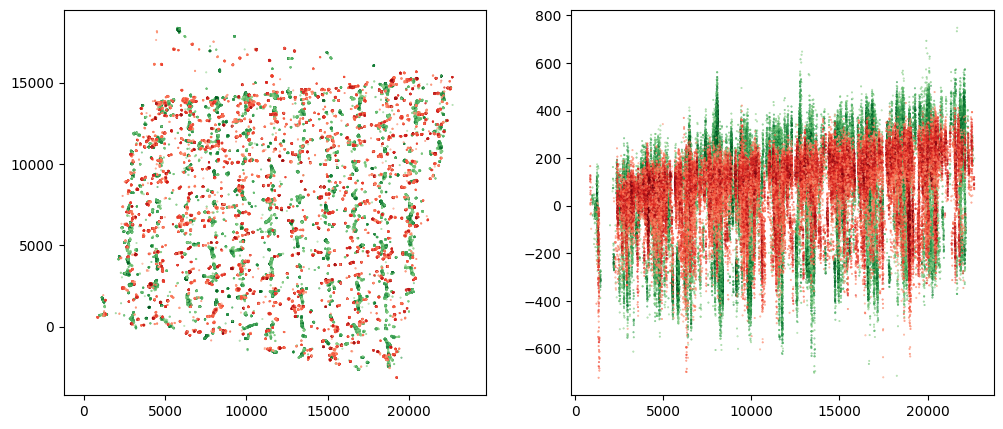

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(
    *(points_rotated.T[:2]),
    c=np.log10(1 / vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)
axes[1].scatter(
    *(points_rotated.T[np.array([0, 2])]),
    c=np.log10(1 / vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)

axes[0].scatter(
    *(points_rotated_desmin.T[:2]),
    c=np.log10(1 / vols_desmin),
    cmap="Reds",
    **scatter_kwargs,
)
axes[1].scatter(
    *(points_rotated_desmin.T[np.array([0, 2])]),
    c=np.log10(1 / vols_desmin),
    cmap="Reds",
    **scatter_kwargs,
)

axes[0].axis("equal")

In [36]:
clusterer = HDBSCAN(min_cluster_size=1000, min_samples=20, cluster_selection_epsilon=50)
clusterer.fit(points_rotated[:, np.array([0, 2])])


HDBSCAN(cluster_selection_epsilon=50, min_cluster_size=1000, min_samples=20)

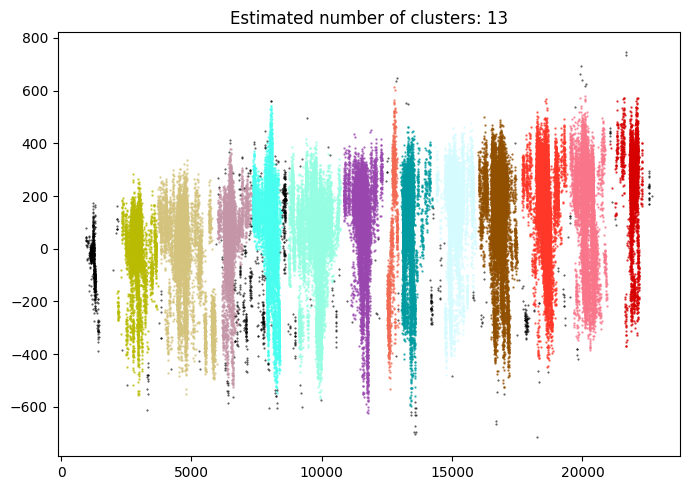

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated[:, np.array([0, 2])], clusterer.labels_, ax=ax)

In [ ]:
sklearn.metrics.calinski_harabasz_score(
    points_rotated[:, np.array([0, 2])], clusterer.labels_
)

632494.7032591691

(array([1.450e+02, 4.350e+02, 2.900e+01, 0.000e+00, 1.000e+00, 4.400e+01,
        9.700e+01, 7.160e+02, 3.424e+03, 2.398e+03, 2.740e+02, 1.810e+02,
        2.610e+02, 3.340e+02, 5.300e+02, 5.850e+02, 4.926e+03, 4.689e+03,
        2.270e+02, 3.490e+02, 3.750e+02, 2.700e+02, 1.005e+03, 1.450e+02,
        1.852e+03, 5.115e+03, 8.480e+02, 2.850e+02, 2.660e+02, 7.020e+02,
        9.010e+02, 1.175e+03, 5.272e+03, 4.154e+03, 5.620e+02, 2.400e+02,
        9.350e+02, 6.970e+02, 7.580e+02, 1.157e+03, 5.243e+03, 3.598e+03,
        8.490e+02, 4.710e+02, 2.150e+02, 1.720e+02, 1.530e+02, 9.120e+02,
        5.076e+03, 3.645e+03, 4.150e+02, 1.700e+02, 9.500e+01, 6.480e+02,
        7.780e+02, 2.100e+02, 4.106e+03, 5.687e+03, 2.620e+02, 9.600e+01,
        1.310e+02, 6.400e+01, 6.900e+01, 4.420e+02, 4.096e+03, 2.930e+03,
        8.920e+02, 2.410e+02, 5.110e+02, 2.160e+02, 7.140e+02, 1.145e+03,
        3.329e+03, 4.955e+03, 1.118e+03, 1.990e+02, 3.700e+01, 2.780e+02,
        1.600e+02, 1.472e+03, 4.448e+0

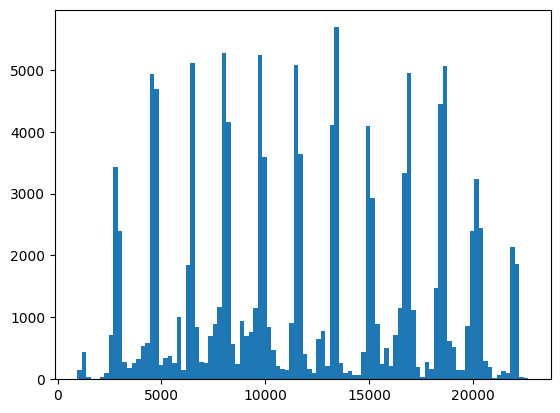

In [39]:
plt.hist(points_rotated[:, 0], bins=100)

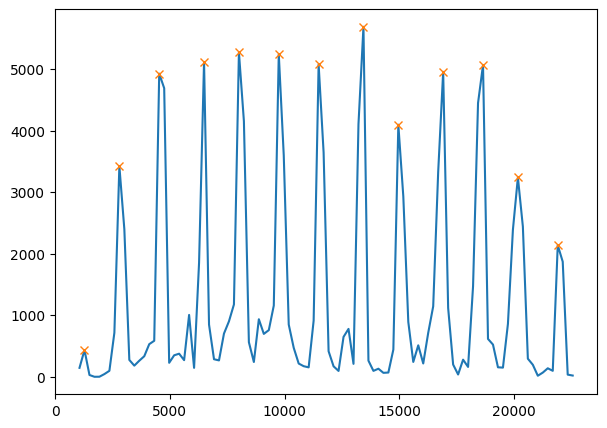

In [ ]:
import scipy


counts, bin_edges = np.histogram(points_rotated[:, 0], bins=100)
bin_pos = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Find peaks with separation more than the known sarcomere length (~1.6um)
peaks, _ = scipy.signal.find_peaks(counts, distance=1500 / (bin_pos[1] - bin_pos[0]))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(bin_pos, counts)
ax.plot(bin_pos[peaks], counts[peaks], "x")

In [41]:
actinin_distances = np.min(
    np.abs(points_rotated[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)
desmin_distances = np.min(
    np.abs(points_rotated_desmin[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)

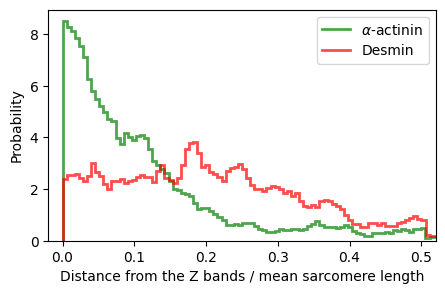

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_sarcomere_length = np.mean(np.diff(bin_pos[peaks]))
ax.stairs(
    *np.histogram(
        actinin_distances / mean_sarcomere_length,
        bins=100,
        density=True,
    ),
    alpha=0.7,
    linewidth=2.0,
    color="green",
    label=r"$\alpha$-actinin",
)
ax.stairs(
    *np.histogram(
        desmin_distances / mean_sarcomere_length,
        bins=100,
        density=True,
    ),
    alpha=0.7,
    linewidth=2.0,
    color="red",
    label="Desmin",
)
ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Probability")
ax.set_xlim((-0.02, 0.52))
ax.legend()

In [62]:
clusterer = HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_epsilon=50)
clusterer.fit(points_rotated)

HDBSCAN(cluster_selection_epsilon=50, min_samples=1)

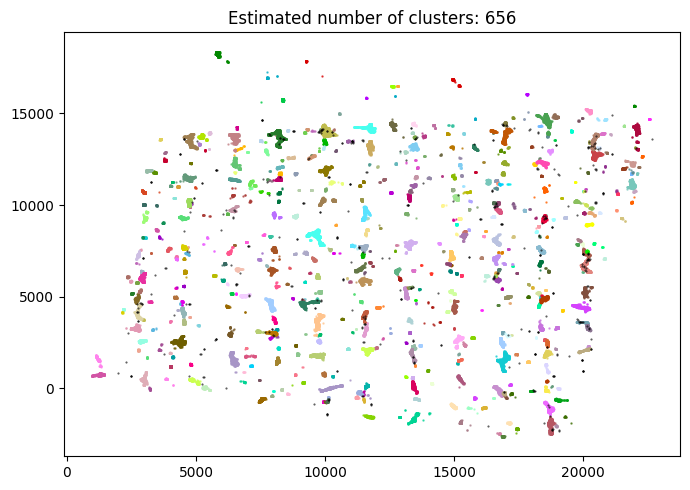

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated[:, np.array([0, 1])], clusterer.labels_, ax=ax)

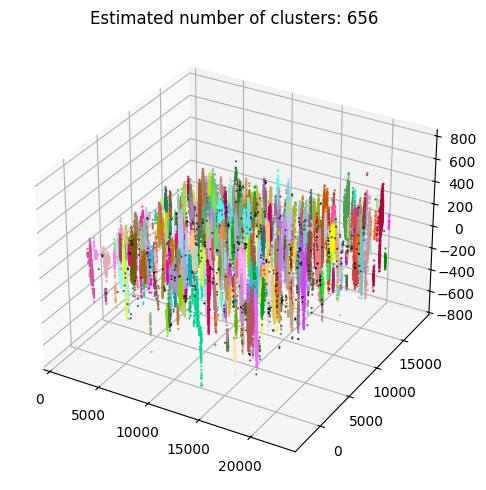

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
plot(points_rotated, clusterer.labels_, ax=ax)

In [69]:
cluster_vol_actinin = []
cluster_cm_actinin = []
unique_labels = set(clusterer.labels_)
for lb in tqdm(unique_labels):
    if lb == -1:
        continue
    cluster_points = points_rotated[clusterer.labels_ == lb]
    cluster_hull = scspatial.ConvexHull(cluster_points)
    cluster_vol_actinin.append(cluster_hull.volume)
    cm = np.mean(cluster_hull.points[cluster_hull.vertices, :], axis=0)
    cluster_cm_actinin.append(cm)
cluster_vol_actinin = np.asarray(cluster_vol_actinin)
cluster_cm_actinin = np.stack(cluster_cm_actinin, axis=0)

100%|██████████| 657/657 [00:00<00:00, 1671.09it/s]


In [71]:
cluster_actinin_distances = np.min(
    np.abs(cluster_cm_actinin[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)

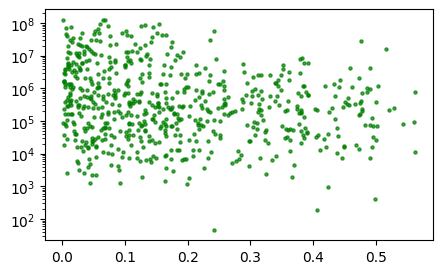

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_sarcomere_length = np.mean(np.diff(bin_pos[peaks]))
ax.scatter(
    cluster_actinin_distances / mean_sarcomere_length,
    cluster_vol_actinin,
    s=5,
    alpha=0.7,
    color="green",
    label=r"$\alpha$-actinin",
)
ax.set_yscale("log", base=10)

In [83]:
clusterer = HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_epsilon=30)
clusterer.fit(points_rotated_desmin)

HDBSCAN(cluster_selection_epsilon=30, min_samples=1)

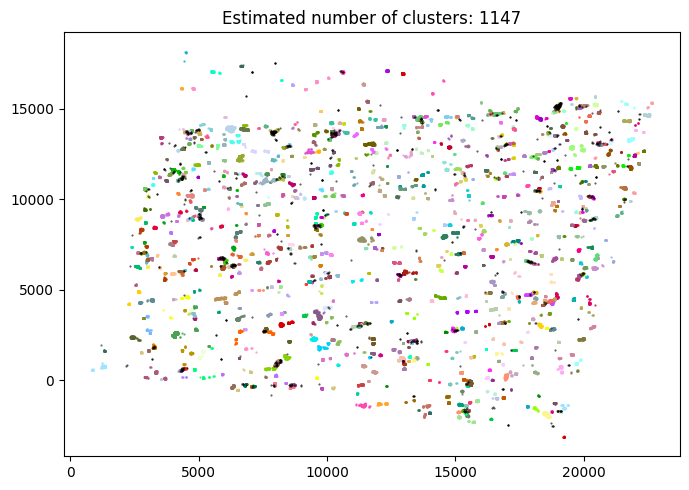

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated_desmin[:, np.array([0, 1])], clusterer.labels_, ax=ax)

In [86]:
cluster_vol_desmin = []
cluster_cm_desmin = []
unique_labels = set(clusterer.labels_)
for lb in tqdm(unique_labels):
    if lb == -1:
        continue
    try:
        cluster_points = points_rotated_desmin[clusterer.labels_ == lb]
        cluster_hull = scspatial.ConvexHull(cluster_points)
        cluster_vol_desmin.append(cluster_hull.volume)
        cm = np.mean(cluster_hull.points[cluster_hull.vertices, :], axis=0)
        cluster_cm_desmin.append(cm)
    except scspatial.QhullError:
        continue
cluster_vol_desmin = np.asarray(cluster_vol_desmin)
cluster_cm_desmin = np.stack(cluster_cm_desmin, axis=0)

100%|██████████| 1148/1148 [00:00<00:00, 3066.35it/s]


In [87]:
cluster_desmin_distances = np.min(
    np.abs(cluster_cm_desmin[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)

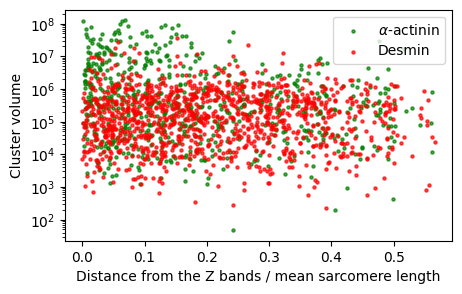

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_sarcomere_length = np.mean(np.diff(bin_pos[peaks]))
ax.scatter(
    cluster_actinin_distances / mean_sarcomere_length,
    cluster_vol_actinin,
    s=5,
    alpha=0.7,
    color="green",
    label=r"$\alpha$-actinin",
)
ax.scatter(
    cluster_desmin_distances / mean_sarcomere_length,
    cluster_vol_desmin,
    s=5,
    alpha=0.7,
    color="red",
    label=r"Desmin",
)
ax.set_yscale("log", base=10)
ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Cluster volume")
ax.legend()

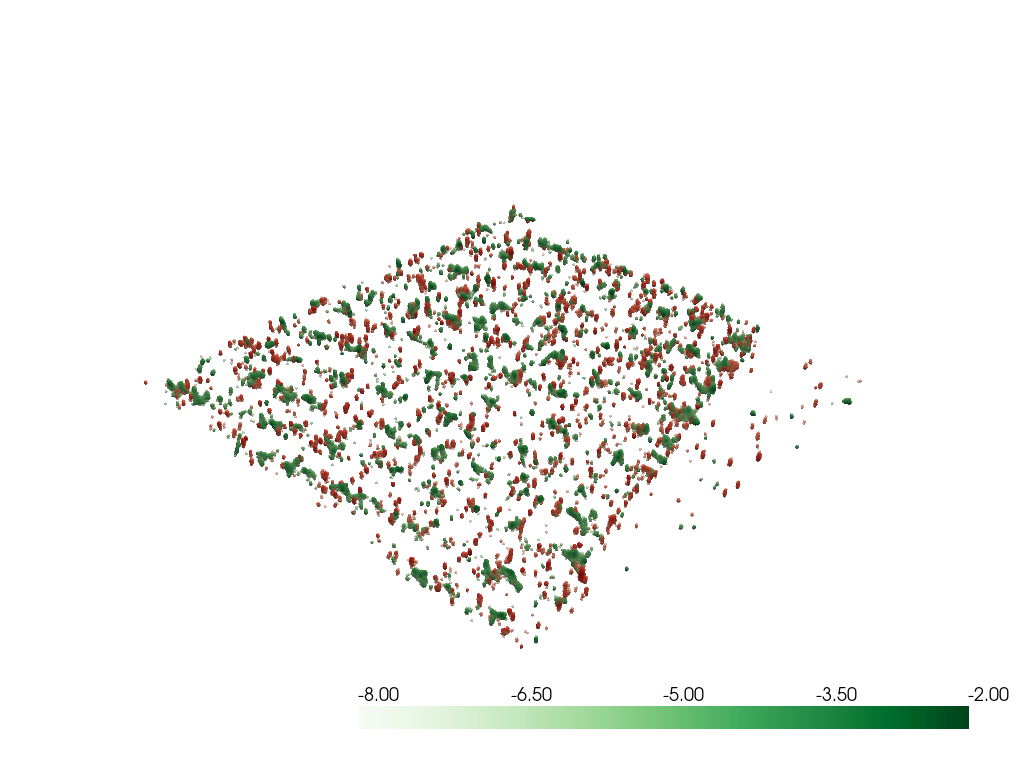

In [ ]:
p = pv.Plotter()
point_cloud_desmin = pv.PolyData(points_desmin_filtered)
point_cloud_actinin = pv.PolyData(points_actinin_filtered)
p.add_mesh(
    point_cloud_desmin,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vols_desmin),
    cmap="Reds",
    show_edges=False,
    opacity=0.5,
    clim=(-8, -2),
)
p.add_mesh(
    point_cloud_actinin,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vols_actinin),
    cmap="Greens",
    show_edges=False,
    opacity=0.5,
    clim=(-8, -2),
)
# p.camera_position = "xy"
p.show()

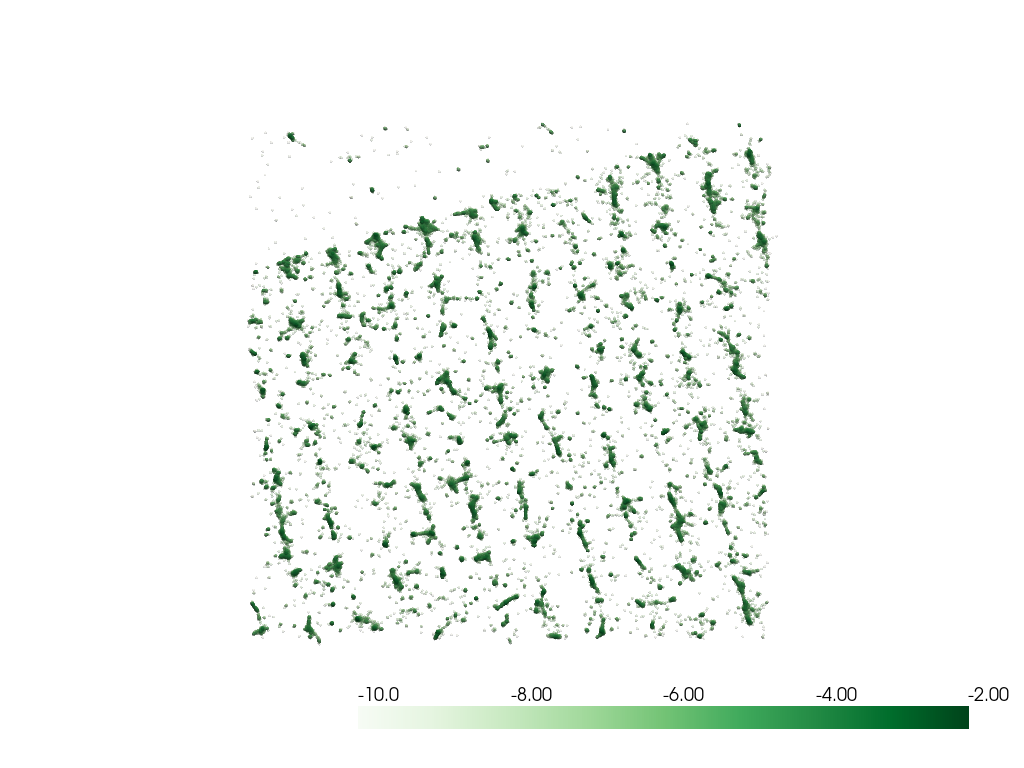

In [55]:
p = pv.Plotter()
point_cloud = pv.PolyData(points)
p.add_mesh(
    point_cloud,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vol + 1e-18),
    cmap="Greens",
    clim=(-10, -2),
    show_edges=False,
    opacity=0.3,
)
p.camera_position = "xy"
p.show()

In [84]:
points.shape

(134279, 3)

In [85]:
vol.shape

(134279,)

In [86]:
grids = np.meshgrid(*[np.arange(b_min[i], b_max[i], 20) for i in range(len(b_min))])
grids[0].shape

(952, 959, 30)

In [87]:
grids = np.stack(grids, axis=-1)

In [88]:
grids.shape

(952, 959, 30, 3)

In [ ]:
import scipy.interpolate as scinterpolate


interpolator = scinterpolate.RBFInterpolator(points, 1 / vol + 1e-18, neighbors=500)
interp_results = scinterpolate.griddata(points, 1 / vol + 1e-18, grids.reshape(-1, 3))

In [90]:
out = interp_results.reshape(*grids.shape[:-1])

In [91]:
density = 1 / vol
np.min(density[density > 0])

np.float64(2.129564936558756e-18)

(array([3.041800e+04, 8.200000e+01, 1.140000e+02, 1.520000e+02,
        2.060000e+02, 2.960000e+02, 4.300000e+02, 6.410000e+02,
        8.840000e+02, 1.213000e+03, 1.686000e+03, 2.197000e+03,
        2.750000e+03, 3.145000e+03, 3.129000e+03, 2.468000e+03,
        1.807000e+03, 2.395000e+03, 3.382000e+03, 4.567000e+03,
        5.945000e+03, 8.131000e+03, 1.086600e+04, 1.252100e+04,
        1.437100e+04, 1.506100e+04, 1.777500e+04, 2.446100e+04,
        3.006100e+04, 3.458600e+04, 4.029300e+04, 4.442000e+04,
        4.963100e+04, 4.889600e+04, 4.646800e+04, 5.107800e+04,
        6.487800e+04, 7.281300e+04, 7.079000e+04, 6.911000e+04,
        9.101900e+04, 1.141700e+05, 1.299290e+05, 1.273580e+05,
        1.208600e+05, 1.127110e+05, 1.245160e+05, 1.574150e+05,
        1.775980e+05, 2.311830e+05, 2.651020e+05, 3.272720e+05,
        3.980720e+05, 4.649030e+05, 5.061350e+05, 5.567360e+05,
        6.299040e+05, 7.890790e+05, 9.457690e+05, 1.129197e+06,
        1.362705e+06, 1.599159e+06, 1.78

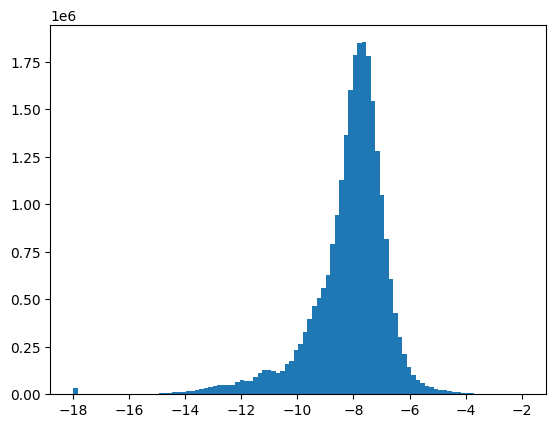

In [92]:
plt.hist(np.log10(interp_results), bins=100)

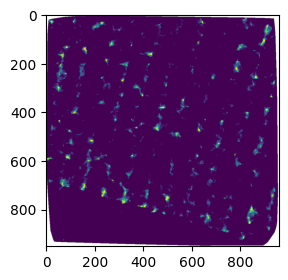

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.imshow(
    np.log10(out[:, :, 10]),
    vmin=np.log10(1 / 0.6e6) - 1,
    vmax=np.log10(1 / 0.6e6) + 1,
)

In [89]:
np.log10(1 / 0.6e6)

np.float64(-5.778151250383644)

/tmp/ipykernel_850234/1718147273.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(interp_results).flatten(), bins=100)


ValueError: supplied range of [-inf, -2.31724829161289] is not finite

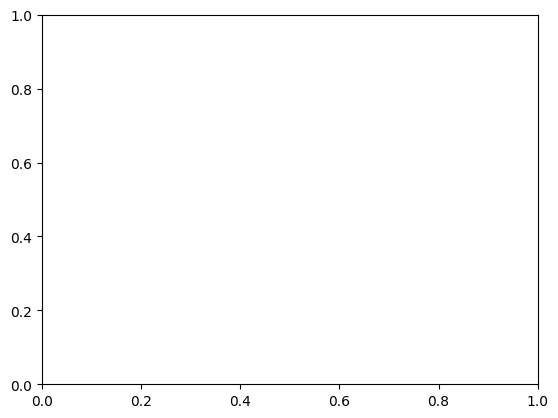

In [34]:
plt.hist(np.log10(interp_results).flatten(), bins=100)